In [23]:
# Import required libraries
from fastai.vision.all import *
import matplotlib.pyplot as plt

#  A.1 Download the data (Assuming already downloaded & extracted into 'data/')
path = Path('dataset/garbage_classification')  # Change this to your actual folder

# A.1.1 Inspect the folder layout
path.ls()


(#12) [Path('dataset/garbage_classification/biological'),Path('dataset/garbage_classification/trash'),Path('dataset/garbage_classification/metal'),Path('dataset/garbage_classification/green-glass'),Path('dataset/garbage_classification/cardboard'),Path('dataset/garbage_classification/clothes'),Path('dataset/garbage_classification/paper'),Path('dataset/garbage_classification/battery'),Path('dataset/garbage_classification/brown-glass'),Path('dataset/garbage_classification/white-glass'),Path('dataset/garbage_classification/plastic'),Path('dataset/garbage_classification/shoes')]

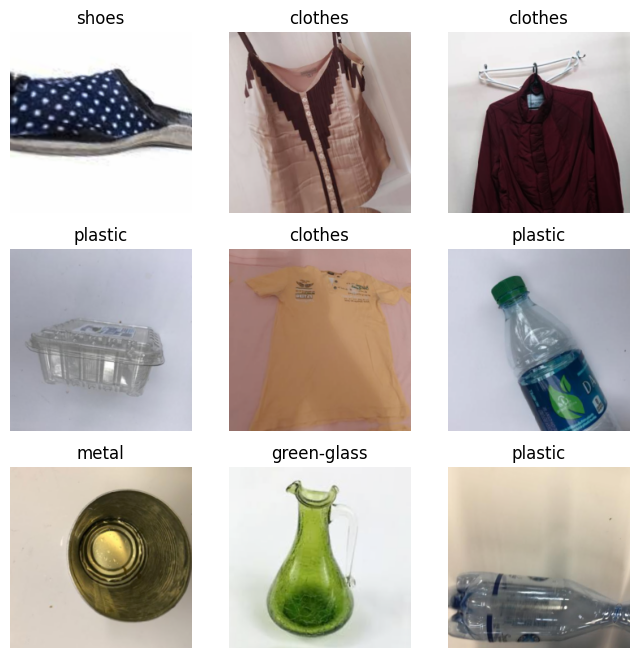

In [25]:
# A.2. Create the DataBlock and dataloaders
garbage_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),             # A.2.1 Define blocks
    get_items=get_image_files,                      # A.2.2 How to get images
    get_y=parent_label,                             # A.2.3 Get label from folder name
    splitter=RandomSplitter(valid_pct=0.25, seed=42),# Split train/valid
    item_tfms=Resize(460),                          # A Word on Presizing (larger resize first)
    batch_tfms=aug_transforms(size=224)             # A.2.4 Batch transforms
)

dls = garbage_block.dataloaders(path, bs=64)

#  A.3.1 Show batch
dls.show_batch(max_n=9, figsize=(8, 8))

In [26]:
# A.3.2 Check labels
print(dls.vocab)
print(f"Number of classes: {len(dls.vocab)}")


['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Number of classes: 12


In [27]:
# A.4.1 Train a simple model (benchmark)
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(5)


epoch,train_loss,valid_loss,accuracy,time
0,0.601984,0.261529,0.917483,00:28


epoch,train_loss,valid_loss,accuracy,time
0,0.294402,0.181543,0.940691,00:35
1,0.210894,0.175036,0.947138,00:35
2,0.134089,0.129129,0.964415,00:36
3,0.086753,0.122401,0.966735,00:35
4,0.044422,0.119373,0.968283,00:35


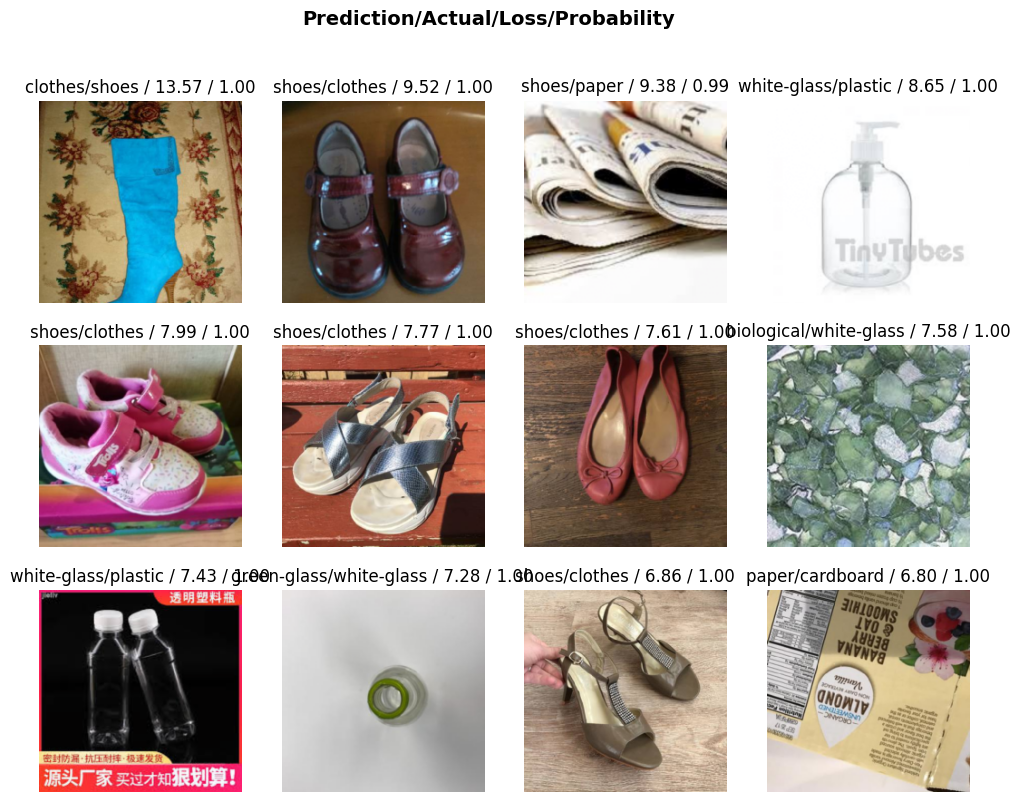

In [29]:
# A.4.2 Interpret model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(12, nrows=3)

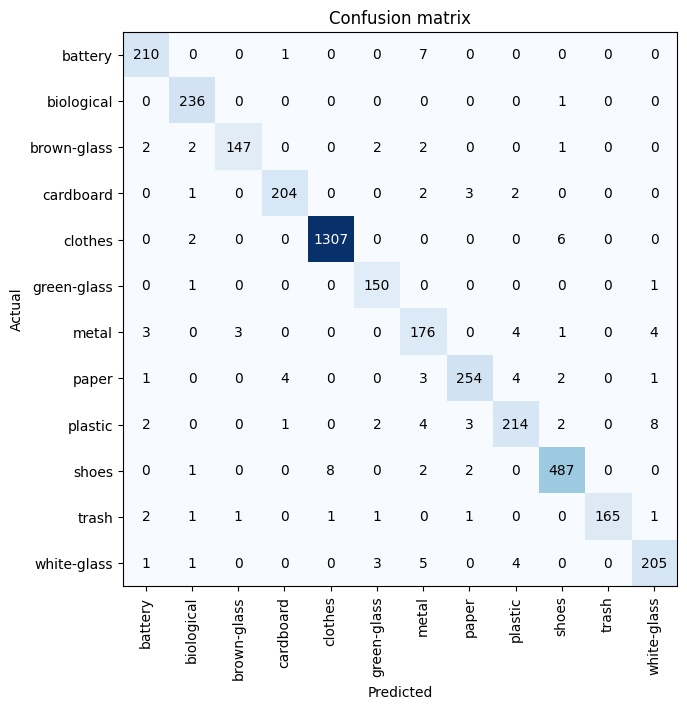

In [30]:
# A.4.3 Confusion Matrix
interp.plot_confusion_matrix(figsize=(7, 7), dpi=100)


SuggestedLRs(valley=3.311311274956097e-06)

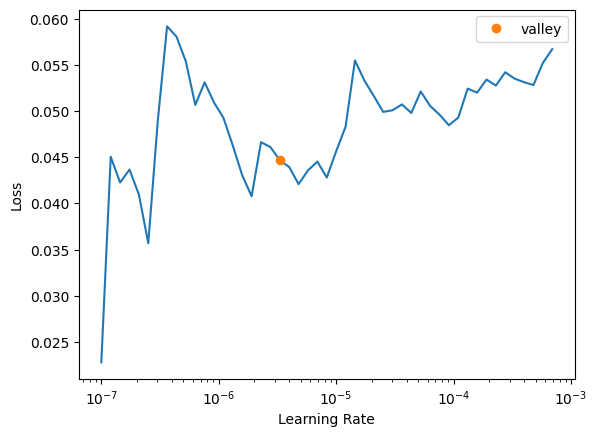

In [31]:
# B.1 Learning Rate Finder
learn.lr_find()


In [32]:
# Choose best learning rate
# Let's pick value just before loss shoots up
learn.fine_tune(4, base_lr=5e-6)
learn.export('models/model1.pkl')


epoch,train_loss,valid_loss,accuracy,time
0,0.048222,0.121291,0.965446,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.046300,0.120177,0.966735,00:35
1,0.044257,0.120653,0.965446,00:35
2,0.047741,0.119484,0.965962,00:36
3,0.045233,0.117406,0.966478,00:37


In [33]:
# B.3 Transfer Learning
# used resnet18; the last layer is replaced by fastai
learn.model[1]


Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=12, bias=False)
)

In [34]:
# Freeze + Train → Unfreeze + Train (B.3) step
learn.freeze()
learn.fit_one_cycle(3, 5e-6)
learn.unfreeze()
learn.fit_one_cycle(3, lr_max=slice(5e-6, 1e-5))   # B.4 Discriminative LRs
learn.export('models/model2.pkl')


epoch,train_loss,valid_loss,accuracy,time
0,0.044769,0.116335,0.968283,00:30
1,0.049884,0.119357,0.965962,00:30
2,0.044015,0.118541,0.967767,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.043432,0.116785,0.967251,00:35
1,0.046898,0.114197,0.968798,00:36
2,0.039792,0.112919,0.967251,00:35


In [35]:
# ⚖️ B.6 Mixed Precision & Model Capacity
# Use resnet34 or resnet50 and to_fp16
learn = vision_learner(dls, resnet34, metrics=accuracy).to_fp32()
learn.fine_tune(3) # increase epoch
learn.export('models/model3.pkl')

epoch,train_loss,valid_loss,accuracy,time
0,0.557370,0.229293,0.929603,00:42


epoch,train_loss,valid_loss,accuracy,time
0,0.280978,0.179201,0.949458,00:53
1,0.165019,0.131244,0.960805,00:54
2,0.075338,0.109001,0.967767,00:54


/home/alpdemiral/miniconda3/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")



📌 Model 1: ResNet18 — Confusion Matrix


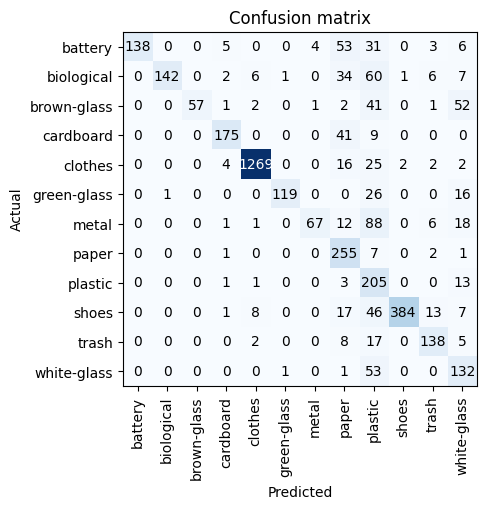


📌 Model 1: ResNet18 — Top Losses


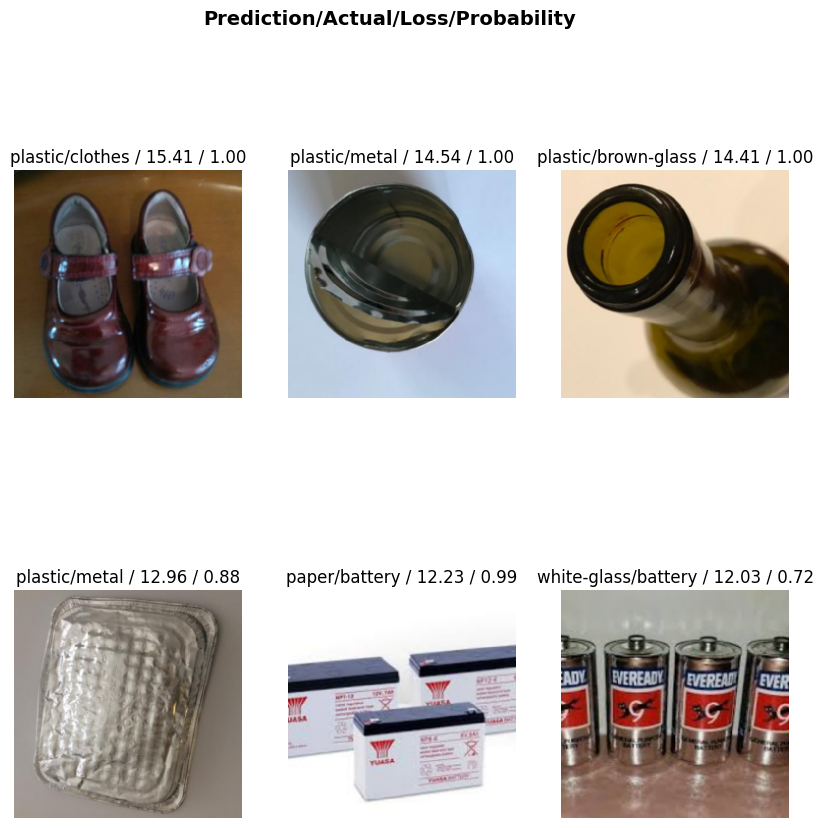

✅ Model 1: ResNet18 Accuracy: 0.7945


/home/alpdemiral/miniconda3/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")



📌 Model 2: ResNet18 Fine-Tuned — Confusion Matrix


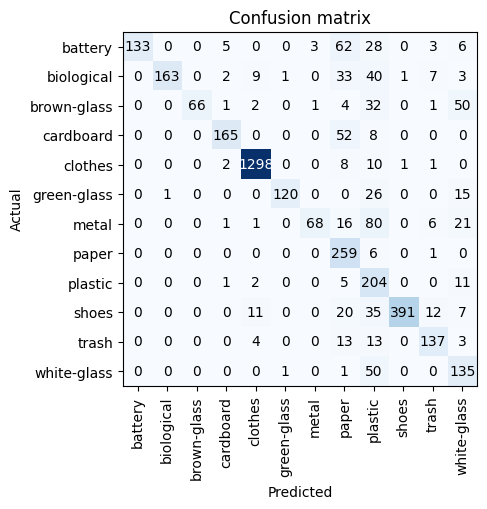


📌 Model 2: ResNet18 Fine-Tuned — Top Losses


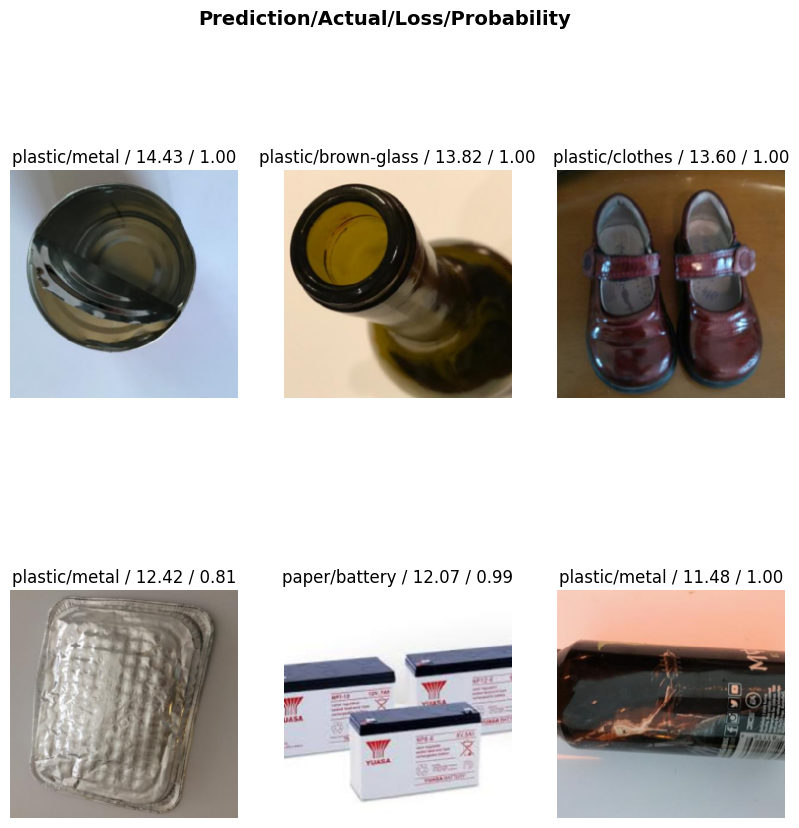

✅ Model 2: ResNet18 Fine-Tuned Accuracy: 0.8094


/home/alpdemiral/miniconda3/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")



📌 Model 3: ResNet50 + Mixed Precision — Confusion Matrix


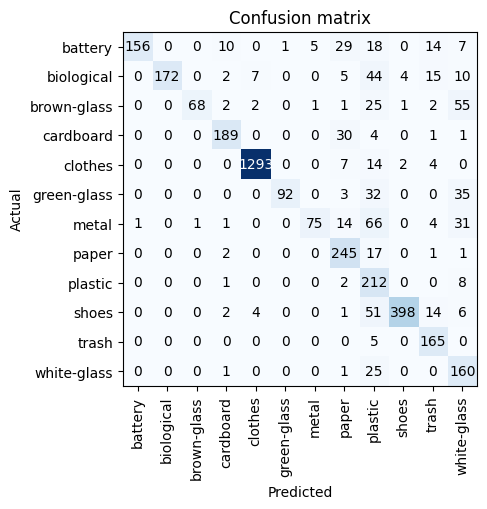


📌 Model 3: ResNet50 + Mixed Precision — Top Losses


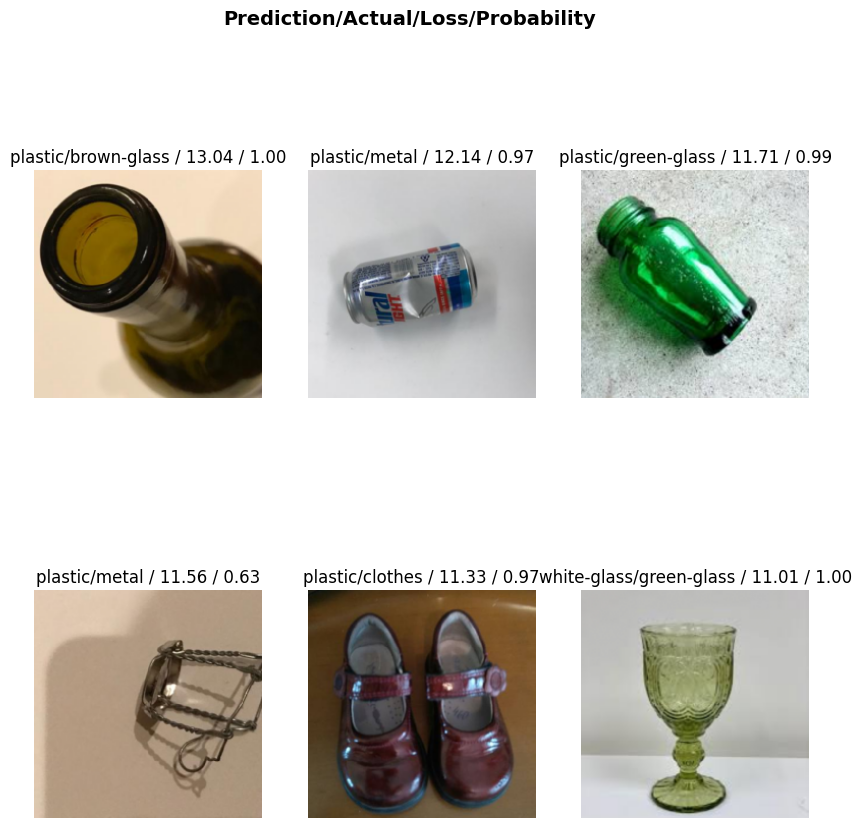

✅ Model 3: ResNet50 + Mixed Precision Accuracy: 0.8316


In [36]:
from fastai.vision.all import *


path = Path('dataset/garbage_classification') 

# load dataloaders using the same setup as before
dls = ImageDataLoaders.from_folder(path, valid_pct=0.25,
                                   item_tfms=Resize(460),
                                   batch_tfms=aug_transforms(size=224),
                                   bs=64)

# Function to load and interpret a model
def interpret_model(model_file, model_name):
    learn = load_learner(model_file)  # Load learner with correct dataloaders
    learn.dls = dls
    interp = ClassificationInterpretation.from_learner(learn)
    
    print(f"\n📌 {model_name} — Confusion Matrix")
    interp.plot_confusion_matrix(figsize=(5, 5))
    plt.show()

    print(f"\n📌 {model_name} — Top Losses")
    interp.plot_top_losses(6, figsize=(10, 10))
    plt.show()

    acc = learn.validate()[1]
    print(f"✅ {model_name} Accuracy: {acc:.4f}")

# Interpret each model
interpret_model('models/model1.pkl', 'Model 1: ResNet18')
interpret_model('models/model2.pkl', 'Model 2: ResNet18 Fine-Tuned')
interpret_model('models/model3.pkl', 'Model 3: ResNet50 + Mixed Precision')
